<h2><center> <span style = "font-family: Babas; font-size: 2em;"> E-commerce Text Classification </span> </center></h2>
<h4><center> <span style = "font-family: Babas; font-size: 2em; font-style: italic"> With TF-IDF and Word2Vec </span> </center></h4>

This code block overrides the behavior of the locale.getpreferredencoding() function to always return "UTF-8" as the preferred encoding, regardless of the system's actual preferred encoding.





In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

---

### Overview

The objective of the project is to classify [**e-commerce**](https://en.wikipedia.org/wiki/E-commerce) products into four categories, based on its description available in the e-commerce platforms. The categories are: `Electronics`, `Household`, `Books`, and `Clothing & Accessories`. We carried out the following steps in this notebook:

- Performed basic [**exploratory data analysis**](https://en.wikipedia.org/wiki/Exploratory_data_analysis), comparing the distributions of the number of characters, number of words, and average word-length of descriptions of products from different categories.
- Employed several [**text normalization**](https://en.wikipedia.org/wiki/Text_normalization) techniques on product descriptions.
- Used [**TF-IDF**](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) vectorizer on the normalized product descriptions for **text vectorization**, compared the baseline performance of several classifiers, and performed [**hyperparameter tuning**](https://en.wikipedia.org/wiki/Hyperparameter_optimization) on the [**support vector machine**](https://en.wikipedia.org/wiki/Support-vector_machine) classifier with **linear kernel**.
- In a separate direction, employed a few selected **text normalization** processes, namely **convertion to lowercase** and **substitution of [contractions](https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions)** on the raw data on product descriptions; used [**Google**](https://en.wikipedia.org/wiki/Google)'s pre-trained [**Word2Vec**](https://en.wikipedia.org/wiki/Word2vec) model on the tokens, obtained from the partially normalized descriptions, to get the [**embeddings**](https://en.wikipedia.org/wiki/Word_embedding), which are then converted to [**compressed sparse row**](https://en.wikipedia.org/wiki/Sparse_matrix) (CSR) format; compared the baseline performance of several classifiers, and performed [**hyperparameter tuning**](https://en.wikipedia.org/wiki/Hyperparameter_optimization) on the [**XGBoost**](https://en.wikipedia.org/wiki/XGBoost) classifier.
- Employed the model with the highest validation accuracy to predict the labels of the test observations and obtained a test accuracy of $0.948939$.

---

### Contents

- [**Introduction**](#Introduction)
    - [E-commerce Product Categorization](#E-commerce-Product-Categorization)
    - [Text Classification](#Text-Classification)
    - [Data](#Data)
    - [Project Objective](#Project-Objective)
- [**Exploratory Data Analysis**](#Exploratory-Data-Analysis)
    - [Class Frequencies](#Class-Frequencies)
    - [Number of Characters](#Number-of-Characters)
    - [Number of Words](#Number-of-Words)
    - [Average Word-length](#Average-Word-length)
- [**Train-Validation-Test Split**](#Train-Validation-Test-Split)
- [**Text Normalization**](#Text-Normalization)
    - [Convertion to Lowercase](#Convertion-to-Lowercase)
    - [Removal of Whitespaces](#Removal-of-Whitespaces)
    - [Removal of Punctuations](#Removal-of-Punctuations)
    - [Removal of Unicode Characters](#Removal-of-Unicode-Characters)
    - [Substitution of Acronyms](#Substitution-of-Acronyms)
    - [Substitution of Contractions](#Substitution-of-Contractions)
    - [Removal of Stop Words](#Removal-of-Stop-Words)
    - [Spelling Correction](#Spelling-Correction)
    - [Stemming and Lemmatization](#Stemming-and-Lemmatization)
    - [Discardment of Non-alphabetic Words](#Discardment-of-Non-alphabetic-Words)
    - [Retainment of Relevant Parts of Speech](#Retainment-of-Relevant-Parts-of-Speech)
    - [Removal of Additional Stop Words](#Removal-of-Additional-Stop-Words)
    - [Integration of the Processes](#Integration-of-the-Processes)
    - [Implementation on Product Description](#Implementation-on-Product-Description)
- [**TF-IDF Model**](#TF-IDF-Model)
    - [Text Vectorization](#Text-Vectorization)
    - [TF-IDF Baseline Modeling](#TF-IDF-Baseline-Modeling)
- [**Word2Vec Model**](#Word2Vec-Model)
    - [Partial Text Normalization](#Partial-Text-Normalization)
    - [Word Embedding](#Word-Embedding)
    - [Word2Vec Baseline Modeling](#Word2Vec-Baseline-Modeling)
- [**Final Prediction and Evaluation**](#Final-Prediction-and-Evaluation)
- [**Acknowledgements**](#Acknowledgements)
- [**References**](#References)

### Importing libraries

In [ ]:
# File system manangement
import time, psutil, os

# Data manipulation
import numpy as np
import pandas as pd

# Plotting and visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_theme()
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# NLP
import string, re, nltk
from string import punctuation
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
!pip install num2words
from num2words import num2words
!pip install pyspellchecker
from spellchecker import SpellChecker
from nltk.stem.porter import PorterStemmer
import spacy
from nltk.stem import WordNetLemmatizer

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Scipy
import scipy
from scipy import sparse
from scipy.sparse import csr_matrix

# Train-test split and cross validation
from sklearn.model_selection import train_test_split, ParameterGrid

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

# Model evaluation
from sklearn import metrics
from sklearn.metrics import accuracy_score

# Others
import json
import gensim
from sklearn.decomposition import TruncatedSVD

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13721 sha256=c9ff866e5ae09e1e3832eabc5e80361a8f879a016f927928733e8a4e4f8b0c33
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 40.1 MB/s eta 0:00:00


### Runtime and memory usage

In [ ]:
# Recording the starting time, complemented with a stopping time check in the end to compute process runtime
start = time.time()

# Class representing the OS process and having memory_info() method to compute process memory usage
process = psutil.Process(os.getpid())

# Introduction

- [**E-commerce Product Categorization**](#E-commerce-Product-Categorization)
- [**Text Classification**](#Text-Classification)
- [**Data**](#Data)
- [**Project Objective**](#Project-Objective)

## E-commerce Product Categorization

**E-commerce** (electronic commerce) is the activity of electronically buying or selling of products on online services or over the [**Internet**](https://en.wikipedia.org/wiki/Internet). It frequently uses the [**web**](https://en.wikipedia.org/wiki/World_Wide_Web), if not entirely, for at least some of the life cycle of a transaction, while it may also use other technologies like [**e-mail**](https://en.wikipedia.org/wiki/Email). Typical e-commerce transactions include the purchase of products (like books from Amazon) or services (such as music downloads in the form of digital distribution such as the iTunes Store). [**Online retail**](https://en.wikipedia.org/wiki/Online_shopping), [**electronic markets**](https://en.wikipedia.org/wiki/Electronic_markets), and [**online auctions**](https://en.wikipedia.org/wiki/Online_auction) are the three areas of e-commerce. E-commerce is supported by [**electronic business**](https://en.wikipedia.org/wiki/Electronic_business). The purpose of e-commerce is to enable customers to shop and pay online over the Internet, saving both time and space for consumers and businesses while also significantly improving transaction efficiency.

**Product categorization** or [**product classification**](https://en.wikipedia.org/wiki/Product_classification) is a type of [**economic taxonomy**](https://en.wikipedia.org/wiki/Economic_taxonomy) that refers to a system of categories into which a collection of products would fall under. Product categorization involves two separate tasks:

- Create, support, and expand the catalogue structure for the offered products.
- Tagging products with the correct categories and attributes.

While machine learning does not have much potential for use in the first task, it is possible to automate the second task, which is relatively laborious and time-consuming. **The problem considered in this notebook involves the categorization of products offered on e-commerce platforms based on the descriptions of the products mentioned therein.** The purpose of such categorization is to enhance the user experience and achieve better results with external search engines. Visitors can quickly find the products they need by navigating the catalogue or using the website's search engine.

## Text Classification

**Text classification** is a widely used [**natural language processing**](https://en.wikipedia.org/wiki/Natural_language_processing) task in different business problems. Given a statement or document, the task involves assigning to it an appropriate category from a pre-defined set of categories. The dataset of choice determines the set of categories. Text classification has applications in emotion classification, news classification, spam email detection, auto-tagging of customer queries etc.

In the present problem, the statements are the product descriptions and the categories are `Electronics`, `Household`, `Books` and `Clothing & Accessories`.

## Data

The dataset has been scraped from Indian e-commerce platform(s). It contains e-commerce text data for four categories: `Electronics`, `Household`, `Books` and `Clothing & Accessories`. Roughly speaking, these four categories cover $80\%$ of any e-commerce website, by and large. The dataset is in *.csv* format and consists of two columns. The first column gives the target class name and the second column gives the datapoint, which is the description of the product from the e-commerce website. We insert column names and swap the columns, to put the target column at the right.

In [ ]:
# Loading and customizing the data
data = pd.read_csv(
    'data.csv', 
    names = ['label', 'description']
)
data = data[['description', 'label']]

print(pd.Series({"Memory usage": "{:.2f} MB".format(data.memory_usage().sum()/(1024*1024)), 
                 "Dataset shape": "{}".format(data.shape)}).to_string())
data

Memory usage        0.77 MB
Dataset shape    (50425, 2)


,description,label
0,Paper Plane Design Framed Wall Hanging Motivat...,Household
1,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",Household
2,SAF 'UV Textured Modern Art Print Framed' Pain...,Household
3,"SAF Flower Print Framed Painting (Synthetic, 1...",Household
4,Incredible Gifts India Wooden Happy Birthday U...,Household
...,...,...
50420,Strontium MicroSD Class 10 8GB Memory Card (Bl...,Electronics
50421,CrossBeats Wave Waterproof Bluetooth Wireless ...,Electronics
50422,Karbonn Titanium Wind W4 (White) Karbonn Titan...,Electronics
50423,"Samsung Guru FM Plus (SM-B110E/D, Black) Colou...",Electronics


In [ ]:
# Example description
data['description'].iloc[0]

'Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch. This painting is ready to hang, you would be proud to possess this unique painting that is a niche apart. We use only the most modern and efficient printing technology on our prints, with only the and inks and precision epson, roland and hp printers. This innovative hd printing technique results in durable and spectacular looking prints of the highest that last a lifetime. We print solely with top-notch 100% inks, to achieve brilliant and true colours. Due to their high level of uv resistance, our prints retain their beautiful colours for many years. Add colour and style to your living space with this digitally printed painting. Some are for pleasure and some for eternal blis

In [ ]:
# Missing values and duplicate observations
print(pd.Series({"Number of observations with missing values": len(data) - len(data.dropna()),
                 "Number of duplicate observations": data.duplicated().sum()}).to_string())

Number of observations with missing values        1
Number of duplicate observations              22622


In [ ]:
data.dropna(inplace = True) # Dropping observations with missing values
data.drop_duplicates(inplace = True) # Dropping duplicate observations
data.reset_index(drop = True, inplace = True) # Resetting index

The labels are manually encoded with the following scheme:
- **Electronics** $\mapsto$ $0$
- **Household** $\mapsto$ $1$
- **Books** $\mapsto$ $2$
- **Clothing & Accessories** $\mapsto$ $3$

In [ ]:
# Manual encoding of labels
label_dict = {'Electronics': 0, 'Household': 1, 'Books': 2, 'Clothing & Accessories': 3}
data.replace({'label': label_dict}, inplace = True)

print(pd.Series({"Memory usage": "{:.2f} MB".format(data.memory_usage().sum()/(1024*1024)),
                 "Dataset shape": "{}".format(data.shape)}).to_string())
data

Memory usage        0.42 MB
Dataset shape    (27802, 2)


,description,label
0,Paper Plane Design Framed Wall Hanging Motivat...,1
1,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",1
2,SAF 'UV Textured Modern Art Print Framed' Pain...,1
3,"SAF Flower Print Framed Painting (Synthetic, 1...",1
4,Incredible Gifts India Wooden Happy Birthday U...,1
...,...,...
27797,Micromax Bharat 5 Plus Zero impact on visual d...,0
27798,Microsoft Lumia 550 8GB 4G Black Microsoft lum...,0
27799,"Microsoft Lumia 535 (Black, 8GB) Colour:Black ...",0
27800,Karbonn Titanium Wind W4 (White) Karbonn Titan...,0


## Project Objective

The objective of the project is to classify a product into the four categories `Electronics`, `Household`, `Books` and `Clothing & Accessories`, based on its description available in the e-commerce platform.

# Exploratory Data Analysis

- [**Class Frequencies**](#Class-Frequencies)
- [**Number of Characters**](#Number-of-Characters)
- [**Number of Words**](#Number-of-Words)
- [**Average Word-length**](#Average-Word-length)

We split the dataset based on the target classes, in order to see how different textual attributes vary across classes.

In [ ]:
# Splitting the dataset by label
data_e = data[data['label'] == 0] # Electronics
data_h = data[data['label'] == 1] # Household
data_b = data[data['label'] == 2] # Books
data_c = data[data['label'] == 3] # Clothing & Accessories

## Number of Characters

This code block visualizes the distribution of the number of characters in product descriptions for four different classes: Electronics, Household, Books, and Clothing & Accessories. The histograms are plotted using seaborn's histplot function and are displayed in a 2x2 subplot. The code also sets the title and axis labels for each subplot.





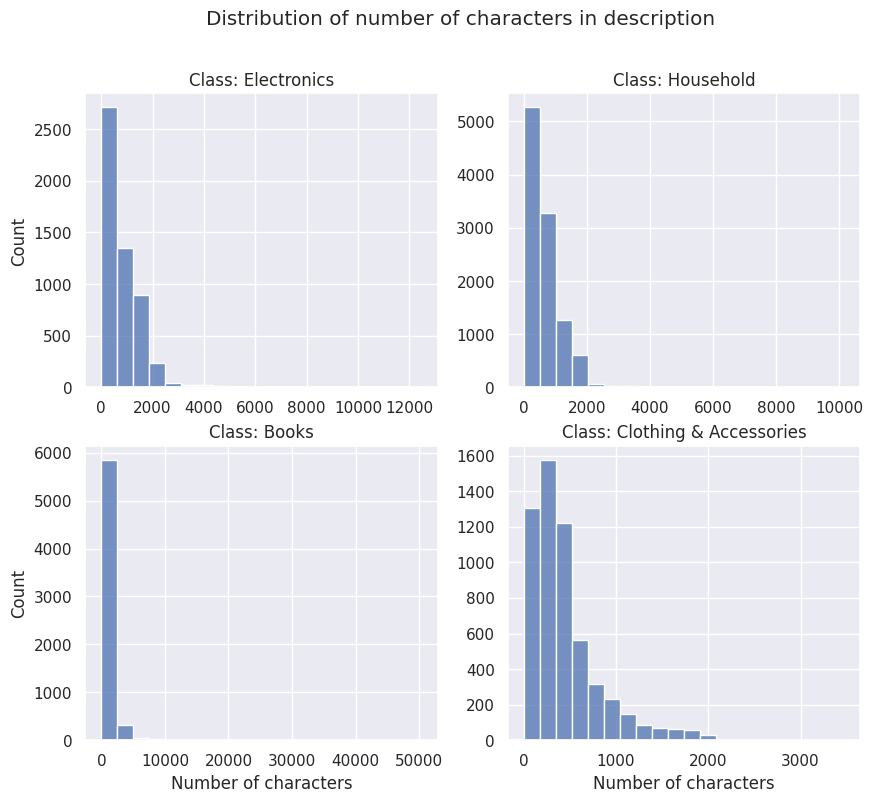

In [ ]:
# Distribution of number of characters in description
data_e_char = data_e['description'].str.len()
data_h_char = data_h['description'].str.len()
data_b_char = data_b['description'].str.len()
data_c_char = data_c['description'].str.len()

fig, ax = plt.subplots(2, 2, figsize = (10, 8.4), sharey = False)
sns.histplot(x = data_e_char, bins = 20, ax = ax[0, 0]).set_title('Class: Electronics')
sns.histplot(x = data_h_char, bins = 20, ax = ax[0, 1]).set_title('Class: Household')
sns.histplot(x = data_b_char, bins = 20, ax = ax[1, 0]).set_title('Class: Books')
sns.histplot(x = data_c_char, bins = 20, ax = ax[1, 1]).set_title('Class: Clothing & Accessories')

fig.suptitle("Distribution of number of characters in description")
for i in range(4):
    ax[i // 2, i % 2].set_xlabel(" ") if i // 2 == 0 else ax[i // 2, i % 2].set_xlabel("Number of characters")
    if i % 2 != 0: ax[i // 2, i % 2].set_ylabel(" ")

## Number of Words

This code block generates histograms to show the distribution of the number of words in the product descriptions of four different categories: Electronics, Household, Books, and Clothing & Accessories. It uses the str.split() function to split the descriptions into words and then uses map() to get the number of words in each description. Finally, it uses sns.histplot() function from the Seaborn library to create histograms for each category.





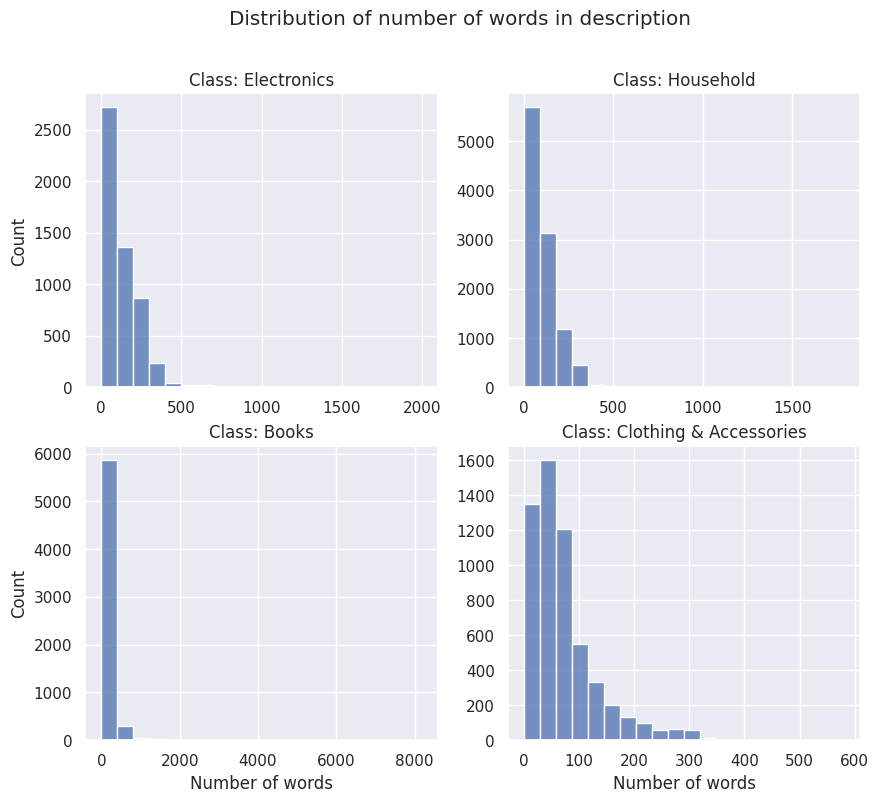

In [ ]:
# Distribution of number of words in description
data_e_word = data_e['description'].str.split().map(lambda x: len(x))
data_h_word = data_h['description'].str.split().map(lambda x: len(x))
data_b_word = data_b['description'].str.split().map(lambda x: len(x))
data_c_word = data_c['description'].str.split().map(lambda x: len(x))

fig, ax = plt.subplots(2, 2, figsize = (10, 8.4), sharey = False)
sns.histplot(x = data_e_word, bins = 20, ax = ax[0, 0]).set_title('Class: Electronics')
sns.histplot(x = data_h_word, bins = 20, ax = ax[0, 1]).set_title('Class: Household')
sns.histplot(x = data_b_word, bins = 20, ax = ax[1, 0]).set_title('Class: Books')
sns.histplot(x = data_c_word, bins = 20, ax = ax[1, 1]).set_title('Class: Clothing & Accessories')

fig.suptitle("Distribution of number of words in description")
for i in range(4):
    ax[i // 2, i % 2].set_xlabel(" ") if i // 2 == 0 else ax[i // 2, i % 2].set_xlabel("Number of words")
    if i % 2 != 0: ax[i // 2, i % 2].set_ylabel(" ")

## Average Word-length

The code block visualizes the distribution of average word length in the description of four classes of products, namely Electronics, Household, Books, and Clothing & Accessories, using the seaborn.histplot() function. The data is processed using the pandas library and NumPy's np.mean() function to calculate the average word length. The resulting figures are displayed in a 2x2 grid using plt.subplots().





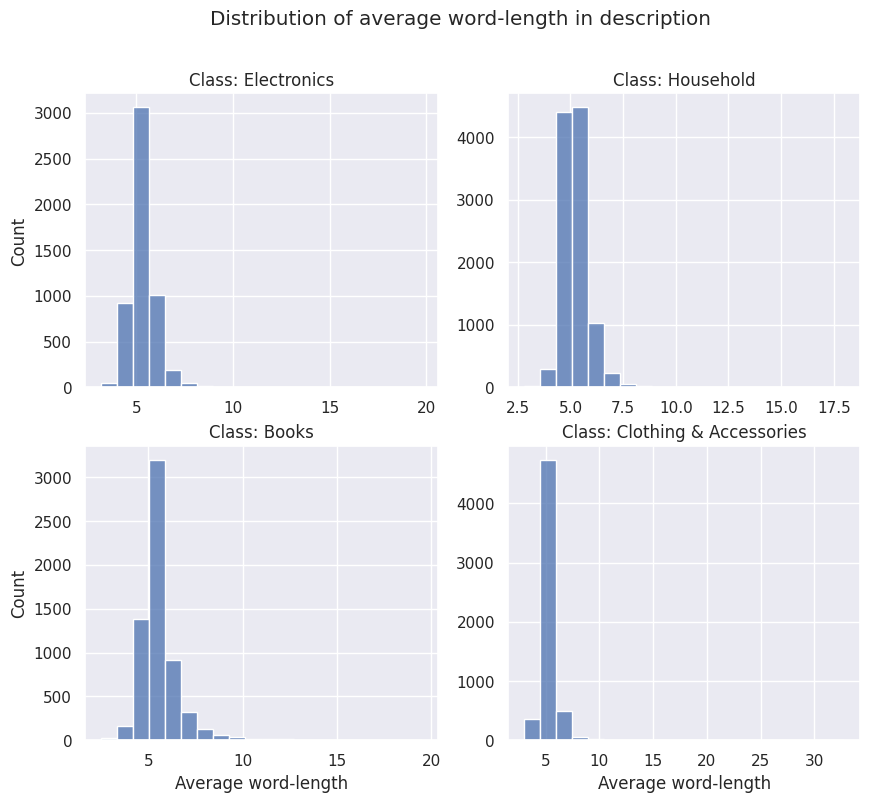

In [ ]:
# Distribution of average word-length in description
data_e_avg = data_e['description'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
data_h_avg = data_h['description'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
data_b_avg = data_b['description'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
data_c_avg = data_c['description'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))

fig, ax = plt.subplots(2, 2, figsize = (10, 8.4), sharey = False)
sns.histplot(x = data_e_avg, bins = 20, ax = ax[0, 0]).set_title('Class: Electronics')
sns.histplot(x = data_h_avg, bins = 20, ax = ax[0, 1]).set_title('Class: Household')
sns.histplot(x = data_b_avg, bins = 20, ax = ax[1, 0]).set_title('Class: Books')
sns.histplot(x = data_c_avg, bins = 20, ax = ax[1, 1]).set_title('Class: Clothing & Accessories')

fig.suptitle("Distribution of average word-length in description")
for i in range(4):
    ax[i // 2, i % 2].set_xlabel(" ") if i // 2 == 0 else ax[i // 2, i % 2].set_xlabel("Average word-length")
    if i % 2 != 0: ax[i // 2, i % 2].set_ylabel(" ")

# Train-Validation-Test Split

This code block performs feature-target split, train-test split, and validation-test split on a given dataset, and compares the sizes of the resulting sets. However, the last part that compares the sizes using a pie chart has been commented out.





In [ ]:
# Feature-target split
X, y = data.drop('label', axis = 1), data['label']

# Train-test split (from complete data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 40)
data_train = pd.concat([X_train, y_train], axis = 1)

# Validation-test split (from test data)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 40)
data_val, data_test = pd.concat([X_val, y_val], axis = 1), pd.concat([X_test, y_test], axis = 1)

# Comparison of sizes of training set, validation set and test set
# values = np.array([len(data_train), len(data_val), len(data_test)])
# labels = ['Training set', 'Validation Set', 'Test set']
# fig = go.Figure(data = [go.Pie(values = values, labels = labels, hole = 0.5, textinfo = 'percent', title = " ")])
# text_title = "Comparison of sizes of training set, validation set and test set"
# fig.update_layout(height = 500, width = 800, showlegend = True, title = dict(text = text_title, x = 0.5, y = 0.95)) 
# fig.show()

# Text Normalization

- [**Convertion to Lowercase**](#Convertion-to-Lowercase)
- [**Removal of Whitespaces**](#Removal-of-Whitespaces)
- [**Removal of Punctuations**](#Removal-of-Punctuations)
- [**Removal of Unicode Characters**](#Removal-of-Unicode-Characters)
- [**Substitution of Acronyms**](#Substitution-of-Acronyms)
- [**Substitution of Contractions**](#Substitution-of-Contractions)
- [**Removal of Stop Words**](#Removal-of-Stop-Words)
- [**Spelling Correction**](#Spelling-Correction)
- [**Stemming and Lemmatization**](#Stemming-and-Lemmatization)
- [**Discardment of Non-alphabetic Words**](#Discardment-of-Non-alphabetic-Words)
- [**Retainment of Relevant Parts of Speech**](#Retainment-of-Relevant-Parts-of-Speech)
- [**Removal of Additional Stop Words**](#Removal-of-Additional-Stop-Words)
- [**Integration of the Processes**](#Integration-of-the-Processes)
- [**Implementation on Product Description**](#Implementation-on-Product-Description)

In natural language processing, **text normalization** is the process of transforming text into a single canonical form. We consider a number of text normalization processes. At the end of the section, we combine selected processes into one single function and apply it on the product descriptions.

In [ ]:
# RegexpTokenizer
regexp = RegexpTokenizer("[\w']+")

## Convertion to Lowercase

We convert all alphabetical characters of the tweets to lowercase so that the models do not differentiate identical words due to case-sensitivity. For example, without the normalization, *Sun* and *sun* would have been treated as two different words, which is not useful in the present context.

In [ ]:
# Converting to lowercase
def convert_to_lowercase(text):
    return text.lower()

text = "This is a FUNCTION that CoNvErTs a Text to lowercase"
print("Input: {}".format(text))
print("Output: {}".format(convert_to_lowercase(text)))

Input: This is a FUNCTION that CoNvErTs a Text to lowercase
Output: this is a function that converts a text to lowercase


## Removal of Whitespaces

We remove the unnecessary empty spaces from the description of the observations.

In [ ]:
# Removing whitespaces
def remove_whitespace(text):
    return text.strip()

text = " \t This is a string \t "
print("Input: {}".format(text))
print("Output: {}".format(remove_whitespace(text)))

Input:  	 This is a string 	 
Output: This is a string


## Removal of Punctuations

Mostly the punctuations do not play any role in predicting whether a particular tweet indicate disaster or not. Thus we prevent them from contaminating the classification procedures by removing them from the tweets. However, we keep **apostrophe** since most of the contractions contain this punctuation and will be automatically taken care of once we convert the contractions.

In [ ]:
# Removing punctuations
def remove_punctuation(text):
    punct_str = string.punctuation
    punct_str = punct_str.replace("'", "") # discarding apostrophe from the string to keep the contractions intact
    return text.translate(str.maketrans("", "", punct_str))

text = "Here's [an] example? {of} &a string. with.? punctuations!!!!"
print("Input: {}".format(text))
print("Output: {}".format(remove_punctuation(text)))

Input: Here's [an] example? {of} &a string. with.? punctuations!!!!
Output: Here's an example of a string with punctuations


## Removal of Unicode Characters

The training tweets are typically sprinkled with emojis, URLs, punctuation and other symbols that do not contribute meaningfully to our analysis, but instead create noise in the learning procedure. Some of these symbols are unique, while the rest usually translate into unicode strings. We remove these irrelevant characters from the data using the regular expression module.

In [ ]:
# Removing HTML tags
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

text = '<a href = "https://ecommerce-text-classification"> Ecommerce Text Classification </a>'
print("Input: {}".format(text))
print("Output: {}".format(remove_html(text)))

Input: <a href = "https://ecommerce-text-classification"> Ecommerce Text Classification </a>
Output:  Ecommerce Text Classification 


This code block defines a function to remove emojis from a given text. It then demonstrates the use of the function by applying it to a sample text input and printing the original and modified text.





In [ ]:
# Removing emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags = re.UNICODE)
    return emoji_pattern.sub(r'', text)

text = "This innovative hd printing technique results in durable and spectacular looking prints 😊"
print("Input: {}".format(text))
print("Output: {}".format(remove_emoji(text)))

Input: This innovative hd printing technique results in durable and spectacular looking prints 😊
Output: This innovative hd printing technique results in durable and spectacular looking prints 


This code block defines a function that removes URLs starting with http or https from the given text input using regular expressions. An example text input is provided along with its output.





In [ ]:
# Removing other unicode characters
def remove_http(text):
    http = "https?://\S+|www\.\S+" # matching strings beginning with http (but not just "http")
    pattern = r"({})".format(http) # creating pattern
    return re.sub(pattern, "", text)

text = "It's a function that removes links starting with http: or https such as https://en.wikipedia.org/wiki/Unicode_symbols"
print("Input: {}".format(text))
print("Output: {}".format(remove_http(text)))

Input: It's a function that removes links starting with http: or https such as https://en.wikipedia.org/wiki/Unicode_symbols
Output: It's a function that removes links starting with http: or https such as 


## Substitution of Acronyms

[**Acronyms**](https://en.wikipedia.org/wiki/Acronym) are shortened forms of phrases, generally found in informal writings. For instance, *for your information* is written as *fyi* and *by the way* is written as *btw*. These time and effort-saving acronyms have received almost universal acceptance in recent times. For the sake of proper modeling, we convert the acronyms, appearing in the tweets, back to their respective original forms.

This code block creates a dictionary of acronyms and reads it from a JSON file located at a specific URL. The dictionary is stored in a pandas Series object called acronyms_dict. An example is then printed to show the original form of an acronym in the dictionary.





In [ ]:
# Dictionary of acronyms
acronyms_url = 'https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/JSON/english_acronyms.json'
acronyms_dict = pd.read_json(acronyms_url, typ = 'series')

print("Example: Original form of the acronym 'fyi' is '{}'".format(acronyms_dict['fyi']))

Example: Original form of the acronym 'fyi' is 'for your information'


In [ ]:
# Dataframe of acronyms
pd.DataFrame(acronyms_dict.items(), columns = ['acronym', 'original']).head()

,acronym,original
0,aka,also known as
1,asap,as soon as possible
2,brb,be right back
3,btw,by the way
4,dob,date of birth


In [ ]:
# List of acronyms
acronyms_list = list(acronyms_dict.keys())

This code block defines a function named convert_acronyms that takes a text as input and converts the acronyms in the text to their original forms. It uses a pre-defined dictionary acronyms_dict that contains the original forms of the acronyms, and a tokenizer named regexp to tokenize the text. The output of the function is the converted text. The code then provides an example of how to use the function on a given text.





In [ ]:
# Function to convert contractions in a text
def convert_acronyms(text):
    words = []
    for word in regexp.tokenize(text):
        if word in acronyms_list:
            words = words + acronyms_dict[word].split()
        else:
            words = words + word.split()
    
    text_converted = " ".join(words)
    return text_converted

text = "btw you've to fill in the details including dob"
print("Input: {}".format(text))
print("Output: {}".format(convert_acronyms(text)))

Input: btw you've to fill in the details including dob
Output: by the way you've to fill in the details including date of birth


## Substitution of Contractions

A [**contraction**](https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions) is a shortened form of a word or a phrase, obtained by dropping one or more letters.

These are commonly used in everyday speech, written dialogue, informal writing and in situations where space is limited or costly, such as advertisements. Usually the missing letters are indicated by an apostrophe, but there are exceptions. Examples: **I'm = I am**, **let's = let us**, **won't = would not**, **howdy = how do you do**.

We have compiled an extensive list of English contractions, which can be found in the attached .json file titled *english_contractions*. The list is largely based on information obtained from [**this wikipedia page**](https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions) on *list of English contractions*. Note that the file only considers contractions in lowercase, i.e. it assumes that the textual data have already been transformed to lowercase before substituting the contractions. For example, the process will convert **i'll** to **i shall** but will leave **I'll** unchanged.

This code block defines a dictionary of English contractions that can be used to convert contractions in text to their expanded forms. The dictionary is loaded from a JSON file hosted on GitHub using the pandas library's read_json() function. An example is given to show how to retrieve the original form of a contraction from the dictionary.





In [ ]:
# Dictionary of contractions
contractions_url = 'https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/JSON/english_contractions.json'
contractions_dict = pd.read_json(contractions_url, typ = 'series')

print("Example: Original form of the contraction 'aren't' is '{}'".format(contractions_dict["aren't"]))

Example: Original form of the contraction 'aren't' is 'are not'


In [ ]:
# Dataframe of contractions
pd.DataFrame(contractions_dict.items(), columns = ['contraction', 'original']).head()

,contraction,original
0,'aight,alright
1,ain't,are not
2,amn't,am not
3,arencha,are not you
4,aren't,are not


The contractions do not always have a one-to-one mapping with the original words. For example **i'd** can come from both **i had** and **i would**. In the .json file only one the original words/phrases are chosen. However, this does not affect our analysis since words like **had** and **would**, which do not have any meaningful contribution in achieving the objective of the project, will be discarded in the next subsection.

In [ ]:
# List of contractions
contractions_list = list(contractions_dict.keys())

This code block defines a function to convert contractions in a text using a dictionary of English contractions. The function splits the text into words and checks if each word is a contraction present in the dictionary. If it is, the function replaces the contraction with its expanded form, and if not, it adds the original word to a list. The function then joins the list of words to form the converted text. The example given shows the input text "he's doin' fine" being converted to "he is doing fine".





In [ ]:
# Function to convert contractions in a text
def convert_contractions(text):
    words = []
    for word in regexp.tokenize(text):
        if word in contractions_list:
            words = words + contractions_dict[word].split()
        else:
            words = words + word.split()
    
    text_converted = " ".join(words)
    return text_converted

text = "he's doin' fine"
print("Input: {}".format(text))
print("Output: {}".format(convert_contractions(text)))

Input: he's doin' fine
Output: he is doing fine


## Removal of Stop Words

Several words, primarily pronouns, prepositions, modal verbs etc, are identified not to have much effect on the classification procedure. These are called [**stop words**](https://en.wikipedia.org/wiki/Stop_word). To get rid of the unwanted contamination effect, we remove these words.

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

This code block defines a list of stopwords in English language, which are commonly used words that do not carry much meaning or contribute to the understanding of the text, such as "the", "a", "an", etc. It adds a few additional words to the list, and creates a new list allstops that includes all the stopwords.





In [ ]:
# Stopwords
stops = stopwords.words("english") # stopwords
addstops = ["among", "onto", "shall", "thrice", "thus", "twice", "unto", "us", "would"] # additional stopwords
allstops = stops + addstops

print(allstops)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

The code defines a function that removes stopwords from a given text using the NLTK library. The function takes a string of text as input and removes all the stopwords from it. The output is a string of text without any stopwords.





In [ ]:
# Function to remove stopwords from a list of texts
def remove_stopwords(text):
    return " ".join([word for word in regexp.tokenize(text) if word not in allstops])

text = "This is a function that removes stopwords in a given text"
print("Input: {}".format(text))
print("Output: {}".format(remove_stopwords(text)))

Input: This is a function that removes stopwords in a given text
Output: This function removes stopwords given text


## Spelling Correction

The classification procedure cannot take mispellings into consideration and treats a word and its misspelt version as separate words. For this reason it is necessary to conduct spelling correction before feeding the data to the classification procedure.

The code block defines a function pyspellchecker that uses the SpellChecker module from the pyspellchecker library to correct spelling errors in a given text. The function tokenizes the input text, identifies misspelled words using spell.unknown(), and then uses spell.correction() to correct the spelling of the identified misspelled words. The corrected words are then joined back to form a corrected text, which is returned by the function. An example is given where the input text is "I'm goinng therre", and the output is the corrected text "I'm going there".





In [ ]:
# pyspellchecker
spell = SpellChecker()

def pyspellchecker(text):
    word_list = regexp.tokenize(text)
    word_list_corrected = []
    for word in word_list:
        if word in spell.unknown(word_list):
            word_corrected = spell.correction(word)
            if word_corrected == None:
                word_list_corrected.append(word)
            else:
                word_list_corrected.append(word_corrected)
        else:
            word_list_corrected.append(word)
    text_corrected = " ".join(word_list_corrected)
    return text_corrected

text = "I'm goinng therre"
print("Input: {}".format(text))
print("Output: {}".format(pyspellchecker(text)))

Input: I'm goinng therre
Output: I'm going there


## Stemming and Lemmatization

[**Stemming**](https://en.wikipedia.org/wiki/Stemming) is the process of reducing the words to their root form or **stem**. It reduces related words to the same *stem* even if the stem is not a dictionary word. For example, the words **introducing**, **introduced**, **introduction** reduce to a common word **introduce**. However, the process often produces stems that are not actual words.

This code block defines a function called text_stemmer that applies stemming to a given text using the Porter stemming algorithm. The function first tokenizes the text, then applies stemming to each token using the stem() method of the PorterStemmer() class from the nltk library. Finally, it joins the stemmed tokens back into a single string and returns it. The code includes an example input and output to demonstrate how the function works.





In [ ]:
# Stemming
stemmer = PorterStemmer()
def text_stemmer(text):
    text_stem = " ".join([stemmer.stem(word) for word in regexp.tokenize(text)])
    return text_stem

text = "Introducing lemmatization as an improvement over stemming"
print("Input: {}".format(text))
print("Output: {}".format(text_stemmer(text)))

Input: Introducing lemmatization as an improvement over stemming
Output: introduc lemmat as an improv over stem


The stems **introduc**, **lemmat** and **improv** are not actual words. [**Lemmatization**](https://en.wikipedia.org/wiki/Lemmatisation) offers a more sophisticated approach by utilizing a corpus to match root forms of the words. Unlike stemming, it uses the context in which a word is being used.

This code block defines a function called text_lemmatizer that takes a text as input and applies lemmatization to it using the en_core_web_sm model from spaCy. The function returns the lemmatized text as output. A sample input and output are also provided.





In [ ]:
# Lemmatization
spacy_lemmatizer = spacy.load("en_core_web_sm", disable = ['parser', 'ner'])
#lemmatizer = WordNetLemmatizer()

def text_lemmatizer(text):
    text_spacy = " ".join([token.lemma_ for token in spacy_lemmatizer(text)])
    #text_wordnet = " ".join([lemmatizer.lemmatize(word) for word in word_tokenize(text)]) # regexp.tokenize(text)
    return text_spacy
    #return text_wordnet

text = "Introducing lemmatization as an improvement over stemming"
print("Input: {}".format(text))
print("Output: {}".format(text_lemmatizer(text)))

Input: Introducing lemmatization as an improvement over stemming
Output: introduce lemmatization as an improvement over stem


## Discardment of Non-alphabetic Words

The non-alphabetic words are not numerous and create unnecessary diversions in the context of classifying tweets into non-disaster and disaster categories. Hence we discard these words.

This code block defines a function to discard non-alphabetic words from a given text. It first tokenizes the text and then selects only those tokens which contain alphabetic characters using the isalpha() method. Finally, it joins the remaining tokens to form the processed text. It demonstrates the usage of the isalpha() method in Python.





In [ ]:
# Discardment of non-alphabetic words
def discard_non_alpha(text):
    word_list_non_alpha = [word for word in regexp.tokenize(text) if word.isalpha()]
    text_non_alpha = " ".join(word_list_non_alpha)
    return text_non_alpha

text = "It is an ocean of thousands and 1000s of crowd"
print("Input: {}".format(text))
print("Output: {}".format(discard_non_alpha(text)))

Input: It is an ocean of thousands and 1000s of crowd
Output: It is an ocean of thousands and of crowd


## Retainment of Relevant Parts of Speech

The [**parts of speech**](https://en.wikipedia.org/wiki/Part_of_speech) provide a great tool to select a subset of words that are more likely to contribute in the classification procedure and discard the rest to avoid noise. The idea is to select a number of parts of speech that are important to the context of the problem. Then we partition the words in a given text into several subsets corresponding to each part of speech and keep only those subsets corresponding to the selected parts of speech. 

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

This code block defines a function keep_pos that uses NLTK's part-of-speech tagging to keep only certain parts of speech in a given text. Specifically, it keeps nouns (NN, NNS, NNP, NNPS, FW), pronouns (PRP, PRPS), adverbs (RB, RBR, RBS), verbs (VB, VBD, VBG, VBN, VBP, VBZ), and some other word types (WDT, WP, WPS, WRB). The function tokenizes the input text, tags each token with its part of speech, and then returns a string of only the tokens with the allowed part of speech tags. The code block also provides an example input text and output to demonstrate the function's functionality.





In [ ]:
def keep_pos(text):
    tokens = regexp.tokenize(text)
    tokens_tagged = nltk.pos_tag(tokens)
    #keep_tags = ['NN', 'NNS', 'NNP', 'NNPS', 'FW']
    keep_tags = ['NN', 'NNS', 'NNP', 'NNPS', 'FW', 'PRP', 'PRPS', 'RB', 'RBR', 'RBS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WPS', 'WRB']
    keep_words = [x[0] for x in tokens_tagged if x[1] in keep_tags]
    return " ".join(keep_words)

text = "He arrived at seven o'clock on Wednesday evening"
print("Input: {}".format(text))
tokens = regexp.tokenize(text)
print("Tokens: {}".format(tokens))
tokens_tagged = nltk.pos_tag(tokens)
print("Tagged Tokens: {}".format(tokens_tagged))
print("Output: {}".format(keep_pos(text)))

Input: He arrived at seven o'clock on Wednesday evening
Tokens: ['He', 'arrived', 'at', 'seven', "o'clock", 'on', 'Wednesday', 'evening']
Tagged Tokens: [('He', 'PRP'), ('arrived', 'VBD'), ('at', 'IN'), ('seven', 'CD'), ("o'clock", 'NN'), ('on', 'IN'), ('Wednesday', 'NNP'), ('evening', 'NN')]
Output: He arrived o'clock Wednesday evening


For an extensive list of part-of-speech tags, see the [**alphabetical list of part-of-speech tags used in the Penn Treebank Project**](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html).

## Removal of Additional Stop Words

Analyzing the data, we observe that several unnecessary words, which are not included in the ready-made set of **stop words**, keep appearing in the text corpus. We discard these words to remove noise in the classification procedure.

This code block defines a list of additional stopwords and a function called remove_additional_stopwords that removes any word from the input text that appears in the additional_stops list. The function returns a string of words without any of the additional stopwords.





In [ ]:
# Additional stopwords

alphabets = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]
prepositions = ["about", "above", "across", "after", "against", "among", "around", "at", "before", "behind", "below", "beside", "between", "by", "down", "during", "for", "from", "in", "inside", "into", "near", "of", "off", "on", "out", "over", "through", "to", "toward", "under", "up", "with"]
prepositions_less_common = ["aboard", "along", "amid", "as", "beneath", "beyond", "but", "concerning", "considering", "despite", "except", "following", "like", "minus", "onto", "outside", "per", "plus", "regarding", "round", "since", "than", "till", "underneath", "unlike", "until", "upon", "versus", "via", "within", "without"]
coordinating_conjunctions = ["and", "but", "for", "nor", "or", "so", "and", "yet"]
correlative_conjunctions = ["both", "and", "either", "or", "neither", "nor", "not", "only", "but", "whether", "or"]
subordinating_conjunctions = ["after", "although", "as", "as if", "as long as", "as much as", "as soon as", "as though", "because", "before", "by the time", "even if", "even though", "if", "in order that", "in case", "in the event that", "lest", "now that", "once", "only", "only if", "provided that", "since", "so", "supposing", "that", "than", "though", "till", "unless", "until", "when", "whenever", "where", "whereas", "wherever", "whether or not", "while"]
others = ["ã", "å", "ì", "û", "ûªm", "ûó", "ûò", "ìñ", "ûªre", "ûªve", "ûª", "ûªs", "ûówe"]
additional_stops = alphabets + prepositions + prepositions_less_common + coordinating_conjunctions + correlative_conjunctions + subordinating_conjunctions + others

def remove_additional_stopwords(text):
    return " ".join([word for word in regexp.tokenize(text) if word not in additional_stops])

## Integration of the Processes

We integrate the text normalization processes in appropriate order. We have kept the **spelling correction** step commented out as it takes a massive amount of time to run on large datasets.

This code block defines a text normalizer function that performs various text preprocessing steps such as converting to lowercase, removing whitespace, removing special characters, removing HTML tags, removing stopwords, lemmatization, and part-of-speech tagging. The function takes a text input and returns the normalized text. It also applies other functions such as removing additional stopwords, discarding non-alphabetic characters, converting acronyms, and contractions. The normalized output is printed.





In [ ]:
def text_normalizer(text):
    text = convert_to_lowercase(text)
    text = remove_whitespace(text)
    text = re.sub('\n' , '', text) # converting text to one line
    text = re.sub('\[.*?\]', '', text) # removing square brackets
    text = remove_http(text)
    text = remove_punctuation(text)
    text = remove_html(text)
    text = remove_emoji(text)
    text = convert_acronyms(text)
    text = convert_contractions(text)
    text = remove_stopwords(text)
#     text = pyspellchecker(text)
    text = text_lemmatizer(text) # text = text_stemmer(text)
    text = discard_non_alpha(text)
    text = keep_pos(text)
    text = remove_additional_stopwords(text)
    return text

text = "We'll combine all functions into 1 SINGLE FUNCTION 🙂 & apply on @product #descriptions https://en.wikipedia.org/wiki/Text_normalization"
print("Input: {}".format(text))
print("Output: {}".format(text_normalizer(text)))

Input: We'll combine all functions into 1 SINGLE FUNCTION 🙂 & apply on @product #descriptions https://en.wikipedia.org/wiki/Text_normalization
Output: combine function function apply product description


## Implementation on Product Description

This code block implements text normalization using the text_normalizer() function on the description column of the data_train, data_val, and data_test dataframes. It then creates new dataframes data_train_norm, data_val_norm, and data_test_norm containing the normalized descriptions and their respective labels. The code block also prints the execution time using %%time.





In [ ]:
%%time
# Implementing text normalization
data_train_norm, data_val_norm, data_test_norm = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

data_train_norm['normalized description'] = data_train['description'].apply(text_normalizer)
data_val_norm['normalized description'] = data_val['description'].apply(text_normalizer)
data_test_norm['normalized description'] = data_test['description'].apply(text_normalizer)

data_train_norm['label'] = data_train['label']
data_val_norm['label'] = data_val['label']
data_test_norm['label'] = data_test['label']

data_train_norm

CPU times: user 5min 36s, sys: 1.81 s, total: 5min 38s
Wall time: 5min 39s


,normalized description,label
15525,approach acupuncture author author graduate al...,2
1536,nice leatherette office arm chair chair seat h...,1
21984,ekan fedora hat girl boy fedora hat hat man fe...,3
25056,concert showlightning controller lighting cont...,0
25213,marantz fully beltdrive premounted cartridge b...,0
...,...,...
23992,apple tablet inch gb wifi gold matter task pro...,0
27640,skin sticker super hero collection fit dell hp...,0
14501,challenger sale take control customer conversa...,2
14555,mathematics work book opinion class,2


# TF-IDF Model

- [**Text Vectorization**](#Text-Vectorization)
- [**TF-IDF Baseline Modeling**](#TF-IDF-Baseline-Modeling)
- [**TF-IDF Hyperparameter Tuning**](#TF-IDF-Hyperparameter-Tuning)

In the context of [**information retrieval**](https://en.wikipedia.org/wiki/Information_retrieval), **TF-IDF** (short for **term frequency-inverse document frequency**), is a numerical statistic that is intended to reflect how important a word is to a document in a collection or [**corpus**](https://en.wikipedia.org/wiki/Text_corpus). It is often used as a weighting factor in searches of **information retrieval**, [**text mining**](https://en.wikipedia.org/wiki/Text_mining), and [**user modeling**](https://en.wikipedia.org/wiki/User_modeling). The **TF-IDF** value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. The term is composed of two factors, **TF** and **IDF**.

[**Term frequency**](https://en.wikipedia.org/wiki/Tf%E2%80%93idf#Term_frequency) **(TF)** is the relative frequency of a term within a given document. It is obtained as the number of times a word appears in a text, divided by the total number of words appearing in the text. Mathematically, it is given by

$$ \text{TF}\left(t, d\right) := \frac{f_{t, d}}{\sum_{t' \in d} f_{t', d}},$$

where $f_{t, d}$ is the number of times that term $t$ appears in the document $d$. Note that the denominator is simply the total number of terms in the document $d$, counting every instance of a given term.

[**Inverse document frequency**](https://en.wikipedia.org/wiki/Tf%E2%80%93idf#Inverse_document_frequency) **(IDF)** measures how common or rare a word is across all documents. It is the logarithmically scaled inverse fraction of the documents that contain the word, obtained by dividing the total number of documents by the number of documents containing the term, and then taking the logarithm of that ratio. Mathematically, it is given by

$$ \text{IDF}\left(t, D\right) := \log{\frac{N}{\left\vert \left\{ d \in D : t \in d \right\} \right\vert}},$$

where $\left\vert S \right\vert$ denotes the cardinality of the set $S$, $N$ is the total number of documents in the corpus, i.e. $N = \left\vert D \right\vert$, and the denominator $\left\vert \left\{ d \in D : t \in d \right\} \right\vert$ is the number of documents where the term $t$ appears. If $t$ is not in the corpus, then $\text{IDF}\left(t, D\right)$ will become undefined. To avoid this, the denominator is often adjusted to $1 + \left\vert \left\{ d \in D : t \in d \right\} \right\vert$. **TF-IDF is the product of the two terms TF and IDF**, i.e.

$$\text{TF-IDF}\left(t, d, D\right) := \text{TF}\left(t, d\right) \times \text{IDF}\left(t, D\right).$$

**It objectively evaluates how relevant a word is to a text in a collection of texts, taking into consideration that some words appear more frequently in general.**

## Text Vectorization

In order to perform machine learning on text data, we must transform the documents into vector representations. In [**natural language processing**](https://en.wikipedia.org/wiki/Natural_language_processing), **text vectorization** is the process of converting words, sentences, or even larger units of text data to numerical vectors.

This code block defines the features and labels for the normalized training, validation, and test datasets by assigning the normalized descriptions to X and the corresponding labels to y.





In [ ]:
# Features and labels
X_train_norm, y_train = data_train_norm['normalized description'].tolist(), data_train_norm['label'].tolist()
X_val_norm, y_val = data_val_norm['normalized description'].tolist(), data_val_norm['label'].tolist()
X_test_norm, y_test = data_test_norm['normalized description'].tolist(), data_test_norm['label'].tolist()

This code block performs TF-IDF vectorization on the normalized text data using scikit-learn's TfidfVectorizer. The resulting TF-IDF vectors are stored in X_train_tfidf, X_val_tfidf, and X_test_tfidf for the train, validation, and test sets respectively.





In [ ]:
# TF-IDF vectorization
TfidfVec = TfidfVectorizer(ngram_range = (1, 1))
X_train_tfidf = TfidfVec.fit_transform(X_train_norm)
X_val_tfidf = TfidfVec.transform(X_val_norm)
X_test_tfidf = TfidfVec.transform(X_test_norm)

## TF-IDF Baseline Modeling

This code block defines the names and models of four classifiers: Logistic Regression, Decision Tree, Random Forest, and SGD Classifier.





In [ ]:
# Classifiers
names = [
    "Logistic Regression",
    "Decision Tree",
    "Random Forest",
    "SGD Classifier",
]

models = [
    LogisticRegression(max_iter = 1000),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators = 20),
    SGDClassifier(loss = 'hinge'),
]

The code defines a function named score which accepts input data and pre-defined classifier models, fits the models on the input data, and returns a summary of the performance of each classifier on the training and validation sets in terms of accuracy. The function then sorts the summary table in descending order of validation accuracy.





In [ ]:
# Function to return summary of baseline models
def score(X_train, y_train, X_val, y_val, names = names, models = models):
    score_df, score_train, score_val = pd.DataFrame(), [], []
    x = time.time()
    for name, model in zip(names, models):
        model.fit(X_train, y_train)
        print(name)
        y_train_pred, y_val_pred = model.predict(X_train), model.predict(X_val)
        score_train.append(accuracy_score(y_train, y_train_pred))
        score_val.append(accuracy_score(y_val, y_val_pred))
    
    score_df["Classifier"], score_df["Training accuracy"], score_df["Validation accuracy"] = names, score_train, score_val
    score_df.sort_values(by = 'Validation accuracy', ascending = False, inplace = True)
    return score_df

In [ ]:
# Summary of baseline models
score(X_train_tfidf, y_train, X_val_tfidf, y_val, names = names, models = models)

Logistic Regression
Decision Tree
Random Forest
SGD Classifier


,Classifier,Training accuracy,Validation accuracy
3,SGD Classifier,0.967942,0.952518
0,Logistic Regression,0.966818,0.943525
2,Random Forest,0.998876,0.919065
1,Decision Tree,0.999955,0.860432


# Word2Vec Model

- [**Partial Text Normalization**](#Partial-Text-Normalization)
- [**Word Embedding**](#Word-Embedding)
- [**Word2Vec Baseline Modeling**](#Word2Vec-Baseline-Modeling)
- [**Word2Vec Hyperparameter Tuning**](#Word2Vec-Hyperparameter-Tuning)

In the context of [**natural language processing**](https://en.wikipedia.org/wiki/Natural_language_processing) (NLP), **word embeddings** are used for representing a word in terms of a real-valued vector that encodes the meaning of the word such that the words that are close in the vector space are expected to be similar in meaning. It can capture the context of a word in a document, as well as identify semantic and syntactic similarity and other contextual relations with other words in the document.

**Word2Vec** is a specific word-embedding technique that uses a neural network model to learn word associations from a reasonably large corpus of text. After training, the model can detect similar words and recommend words to complete a partial sentence. As its name suggests, word2vec maps each distinct word to a vector, which is assigned in such a way that the level of semantic similarity between words is indicated by a simple mathematical operation on the vectors that the words are mapped to (for instance, the cosine similarity between the vectors).

## Partial Text Normalization

Standard text normalization processes like **stemming**, **lemmatization** or **removal of stop words** are not recommended when we have pre-trained embeddings. The reason behind this is that valuable information, which could be used by the neural network, is lost by those preprocessing steps. Here we shall consider a few selected text normalization processes only, before we feed the tokenized words to the pre-trained model to get the embeddings.

This code block defines a function to convert text to lowercase and another function to expand contractions in the text. It also loads a JSON file with a list of English contractions and their expansions.





In [ ]:
# Relevant text normalization processes
def convert_to_lowercase(text): return text.lower()

contractions_url = 'https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/JSON/english_contractions.json'
contractions_dict = pd.read_json(contractions_url, typ = 'series')
contractions_list = list(contractions_dict.keys())

def convert_contractions(text):
    words = []
    for word in regexp.tokenize(text):
        if word in contractions_list:
            words = words + contractions_dict[word].split()
        else:
            words = words + word.split()
    return " ".join(words)

This code block performs text normalization on the product description text data for Word2Vec by converting the text to lowercase, expanding contractions, and tokenizing the text into individual words. It creates a new column "tokens" in each of the data frames data_train, data_val, and data_test which contains the tokenized text data. Finally, it prints the "tokens" and "label" columns of the data_train data frame.





In [ ]:
# Text normalization for Word2Vec
for df in [data_train, data_val, data_test]:
    df['tokens'] = (df["description"].apply(convert_to_lowercase)
                                     .apply(convert_contractions)
                                     .apply(regexp.tokenize))
data_train[['tokens', 'label']]

,tokens,label
15525,"[practical, approach, to, acupuncture, 1, abou...",2
1536,"[nice, goods, leatherette, office, arm, chair,...",1
21984,"[ekan, fashionable, fedora, hat, for, girls, b...",3
25056,"[techyshop, dmx512, professional, concert, sho...",0
25213,"[marantz, tt5005, fully, automatic, belt, driv...",0
...,...,...
23992,"[apple, ipad, pro, mpf12hn, a, tablet, 10, 5, ...",0
27640,"[printelligent, laptop, skins, stickers, super...",0
14501,"[the, challenger, sale, taking, control, of, t...",2
14555,"[international, mathematics, olympiad, work, b...",2


## Word Embedding

In [ ]:
!pip install gdown
!gdown 1gNoYboT6LG3Qx8fubR9dd_U_meBWvyqQ

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From: https://drive.google.com/uc?id=1gNoYboT6LG3Qx8fubR9dd_U_meBWvyqQ
To: /content/GoogleNews-vectors-negative300.bin.gz
100% 1.65G/1.65G [00:16<00:00, 98.4MB/s]


In [ ]:
!gzip -d GoogleNews-vectors-negative300.bin.gz

This code block loads a pre-trained Word2Vec model from a binary file called "GoogleNews-vectors-negative300.bin" using the gensim library. The model is stored in the "word2vec" variable.





In [ ]:
# Loading the pre-trained Word2Vec model
word2vec_path = 'GoogleNews-vectors-negative300.bin'
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary = True)

This code block defines several functions that are useful for working with Word2Vec embeddings, including one that generates the average Word2Vec embedding for a list of tokens, one that generates Word2Vec embeddings for a dataframe of tokenized text, and one that plots the embeddings.





In [ ]:
# Some useful functions for Word2Vec
def get_average_word2vec(tokens_list, vector, generate_missing = False, k = 300):
    if len(tokens_list) < 1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis = 0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, tokens, generate_missing = False):
    embeddings = tokens.apply(lambda x: get_average_word2vec(x, vectors, generate_missing = generate_missing))
    return list(embeddings)

def plot_embedding(X, y):
    truncated_SVD = TruncatedSVD(n_components = 2)
    truncated_SVD.fit(X)
    scores = truncated_SVD.transform(X)
    color_mapper = {label:idx for idx, label in enumerate(set(y))}
    color_column = [color_mapper[label] for label in y]
    colors = ['red', 'blue', 'green', 'black']
        
    plt.scatter(scores[:, 0], scores[:, 1], s = 8, alpha = 0.8, c = y, cmap = matplotlib.colors.ListedColormap(colors))
    red_patch = mpatches.Patch(color = 'red', label = 'Electronics')
    blue_patch = mpatches.Patch(color = 'blue', label = 'Household')
    green_patch = mpatches.Patch(color = 'green', label = 'Books')
    black_patch = mpatches.Patch(color = 'black', label = 'Clothing & Accessories')
    plt.legend(handles = [red_patch, blue_patch, green_patch, black_patch], prop = {"size": 12})

This code block computes Word2Vec embeddings for the training, validation, and test sets and plots the resulting embeddings in a two-dimensional space using t-SNE. The resulting plot visualizes the distribution of the embeddings across the four different product categories.





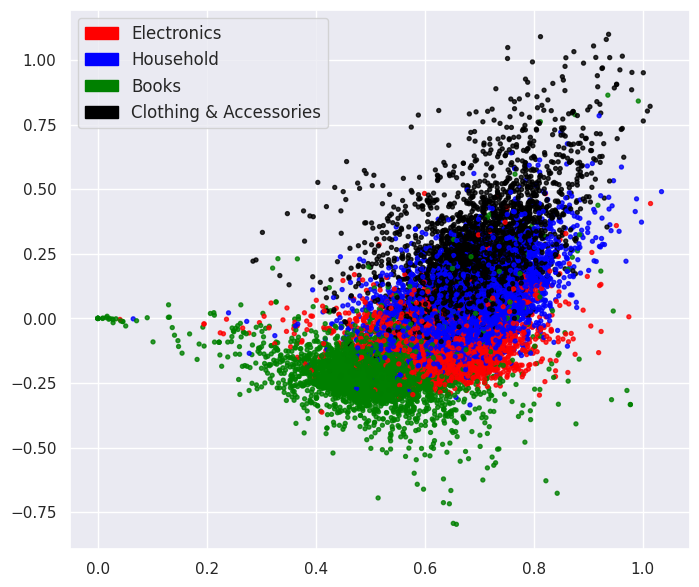

In [ ]:
# Word2Vec embedding
X_train_embed = get_word2vec_embeddings(word2vec, data_train['tokens'])
X_val_embed = get_word2vec_embeddings(word2vec, data_val['tokens'])
X_test_embed = get_word2vec_embeddings(word2vec, data_test['tokens'])

fig = plt.figure(figsize = (8, 7))          
plot_embedding(X_train_embed, y_train)
plt.show()

This code block converts the embeddings obtained from Word2Vec into a compressed sparse row matrix format for the training, validation, and testing sets.





In [ ]:
# Converting to Compressed Sparse Row matrix
X_train_w2v = scipy.sparse.csr_matrix(X_train_embed)
X_val_w2v = scipy.sparse.csr_matrix(X_val_embed)
X_test_w2v = scipy.sparse.csr_matrix(X_test_embed)

## Word2Vec Baseline Modeling

This code block calls the function score() with some input arguments to return a summary of baseline models. The input arguments are preprocessed data (X_train_w2v and X_val_w2v) and pre-trained models (names and models). The function score() fits each model on the training data and predicts the labels for the training and validation data. It then calculates and returns the accuracy scores for each model on the training and validation data. The summary is displayed in a pandas dataframe.





In [ ]:
# Summary of baseline models
score(X_train_w2v, y_train, X_val_w2v, y_val, names = names, models = models)

Logistic Regression
Decision Tree
Random Forest
SGD Classifier


,Classifier,Training accuracy,Validation accuracy
0,Logistic Regression,0.931613,0.929496
3,SGD Classifier,0.930714,0.928417
2,Random Forest,0.999191,0.915827
1,Decision Tree,0.999955,0.811871
